## Lab 13: Bandit algorithms

*   General idea
*   $\varepsilon$-greedy
*   UCB

Suppose that you have several "one-armed bandit" slot machines. All of them have different probabilities of paying off.

Each time you play a machine, you either win or lose. Using this information, you can update your knowleddge about the probability of winning.

Then, to decide which machine to play next, you can use the "Bayesian bandit" strategy.

Multi-armed bandits belong to a class of online learning algorithms that allocate a fixed number of resources to a set of competing choices, attempting to learn an optimal resource allocation policy over time.

The multi-armed bandit problem is often introduced via an analogy of a gambler playing slot machines. Imagine you're at a casino and are presented with a row of $k$ slot machines, with each machine having a hidden payoff function that determines how much it will pay out. You enter the casino with a fixed amount of money and want to learn the best strategy to maximize your profits. Initially you have no information about which machine is expected to pay out the most money, so you try one at random and observe its payout. Now that you have a little more information than you had before, you need to decide: do I exploit this machine now that I know more about its payoff function, or do I explore the other options by pulling arms that I have less information about? You want to strike the most profitable balance between exploring all potential machines so that you don't miss out on a valuable one by simply not trying it enough times, and exploiting the machine that has been most profitable so far.

A multi-armed bandit algorithm is designed to learn an optimal balance for allocating resources between a fixed number of choices in a situation such as this one, maximizing cumulative rewards over time by learning an efficient explore vs. exploit policy.

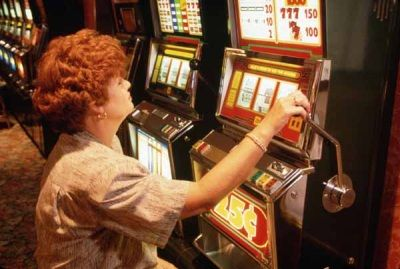
![](https://cassies.ca/wp-content/uploads/2021/04/one-armed-bandit-slot-781x512.jpg)

## General idea


Before looking at any specific algorithms, it's useful to first establish a few definitions and core principles, since the language and problem setup of the bandit setting differs slightly from those of traditional machine learning. The bandit setting, in short, looks like this:

*   You're presented with $k$ distinct "arms" to choose from. An arm can be a piece of content for a recommender system, a stock pick, a promotional offer, etc.
*   Observe information about how these arms have performed in the past, such as how many times the arm has been pulled and what its payoff value was each time.
*   "Pull" the arm (choose the action) deemed best by the algorithm's policy.
*   Observe its reward (how positive the outcome was) and/or its regret (how much worse this action was compared to how the best-possible action would have performed in hindsight).
*   Use this reward and/or regret information to update the policy used to select arms in the future.
*   Continue this process over time, attempting to learn a policy that balances exploration and exploitation in order to minimize cumulative regret.

The time-dependence of a bandit problem (start with zero or minimal information about all arms, learn more over time) is a significant departure from the traditional machine learning problem setting, where the full dataset is available to a model at once, which can be trained as a one-off process. Bandits require repeated, incremental policy updates.

In [1]:
!pip install empiricaldist
!pip install tqdm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.7.2-py3-none-any.whl size=12205 sha256=2ba58be5f1571437bba9d86ca392628237b737f3023e3f38e615fdc4e7ba1a48
  Stored in directory: /Users/dom_iva/Library/Caches/pip/wheels/05/04/80/8f1685c3816f6ce84a1e4e6fae3697ef5a1bb5a91080155342
Successfully built empiricaldist


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import matplotlib.pyplot as plt

from empiricaldist import Pmf # empirical distribution functions,
                              # see more:
                              # https://nbviewer.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb
from tqdm import tqdm

In [3]:
def decorate_bandit(title):
    plt.xlabel('Percentage probability of winning')
    plt.ylabel('PMF')
    plt.title(title)

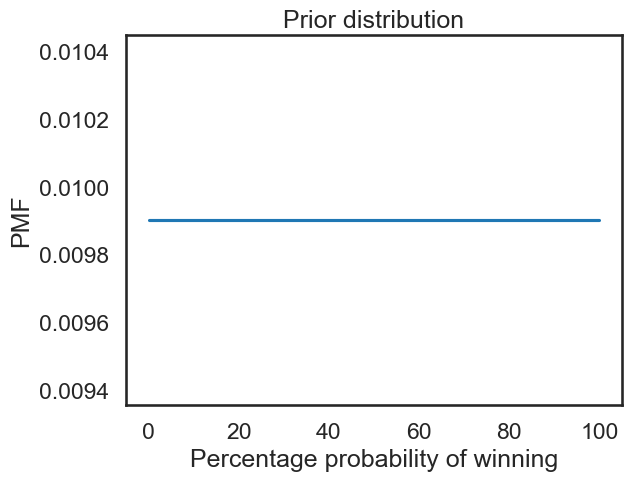

In [4]:
bandit = Pmf.from_seq(range(101))
bandit.plot()
decorate_bandit('Prior distribution')

In [5]:
def likelihood_bandit(data, hypo):
    x = hypo / 100
    if data == 'W':
        return x
    else:
        return 1-x

Suppose that you play a machine 10 times and win once. How will the posterior distribution look like?

W
0.5000000000000001
L
0.32999999999999996
L
0.5
L
0.5999599999999999
L
0.6666111074071605
L
0.7142142821423215
L
0.7499124956247812
L
0.7776740692343835
L
0.7998799952002402
L
0.8180454504555686


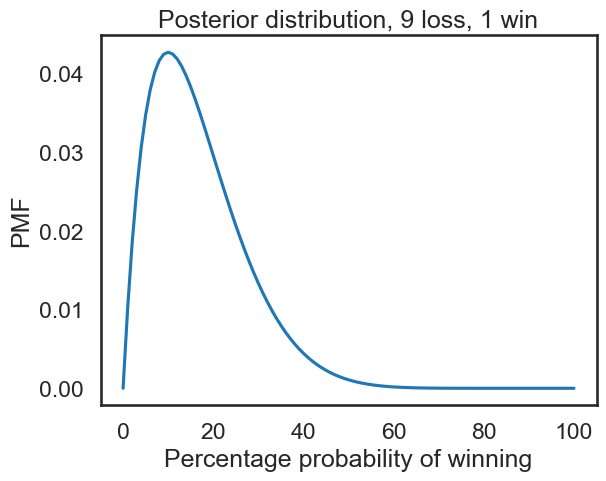

In [6]:
for outcome in 'WLLLLLLLLL':
    print(outcome)
    print(bandit.update(likelihood_bandit, outcome))

bandit.plot()
decorate_bandit('Posterior distribution, 9 loss, 1 win')

Now we suppose that we have several bandits and we want to decide which one would be better to play:

In [7]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

In [8]:
from random import random
from collections import Counter

# count how many times we've played each machine
counter = Counter()

def flip(p): # returns True with probability p
    return random() < p

def play(i): # returns 'W' for winning or 'L' for losing
    counter[i] += 1
    p = actual_probs[i]
    if flip(p):
        return 'W'
    else:
        return 'L'

Here's a test, playing machine 3 twenty times:

In [9]:
for i in range(20):
    result = play(3)
    print(result, end = ' ')

L L W L W L W L L L W W L L L L L L W L 

In [10]:
prior = range(101)
beliefs = [Pmf.from_seq(prior) for i in range(4)]

In [11]:
options = dict(xticklabels = 'invisible', yticklabels = 'invisible')

def plot(beliefs, **options):
    sns.set_context('paper')
    for i, b in enumerate(beliefs):
        plt.subplot(2, 2, i+1)
        b.plot(label = 'Machine %s' % i)
        plt.gca().set_yticklabels([])
        plt.legend()

    plt.tight_layout()
    sns.set_context('talk')

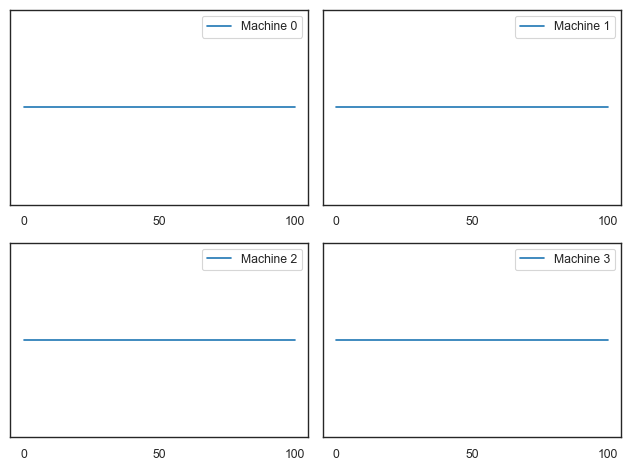

In [12]:
plot(beliefs)

In [13]:
def update(beliefs, i, outcome):
    beliefs[i].update(likelihood_bandit, outcome)

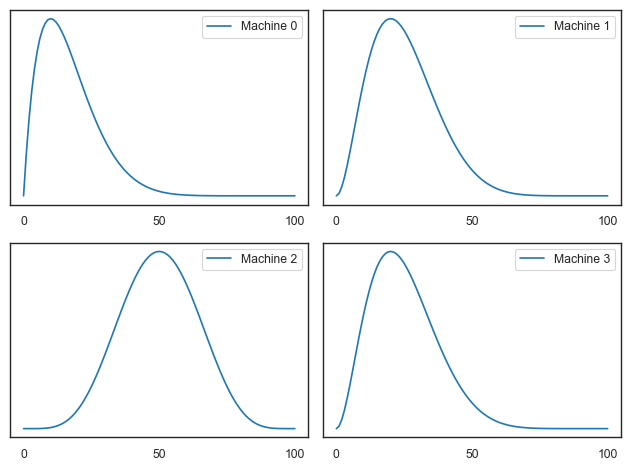

In [14]:
for i in range(4):
    for _ in range(10):
      outcome = play(i)
      update(beliefs, i, outcome)

plot(beliefs)

In [15]:
for i, b in enumerate(beliefs):
    print(b.mean(), b.credible_interval(0.9))

16.68194469884906 [ 3. 36.]
25.000012366755822 [ 8. 47.]
49.99999999999999 [27. 73.]
25.00001236675582 [ 8. 47.]


To get more information, we could play each machine 100 times, but while we are gathering data, we are not making good use of it. The kernel of the Bayesian Bandits algorithm is that it collects and uses data **at the same time**. In other words, it balances exploration and exploitation, as it was mentioned in a theory above.

In [16]:
def choose(beliefs):
    ps = [b.choice() for b in beliefs]
    return np.argmax(ps)

This function chooses one value from the posterior distribution of each machine and then uses argmax to find the index of the machine that chose the highest value.

In [17]:
choose(beliefs)

2

In [18]:
def choose_play_update(beliefs, verbose = False):
    machine = choose(beliefs)           # choose a machine
    outcome = play(machine)             # play it
    update(beliefs, machine, outcome)   # update beliefs
    if verbose:
        print(i, outcome, beliefs[machine].mean())

In [19]:
choose_play_update(beliefs, verbose = True)

3 L 46.15384615485771


Let's start again with a fresh set of machines and an empty Counter.

In [20]:
beliefs = [Pmf.from_seq(prior) for i in range(4)]
counter = Counter()

If we run the bandit algorithm 100 times, we can see how beliefs are getting updated:

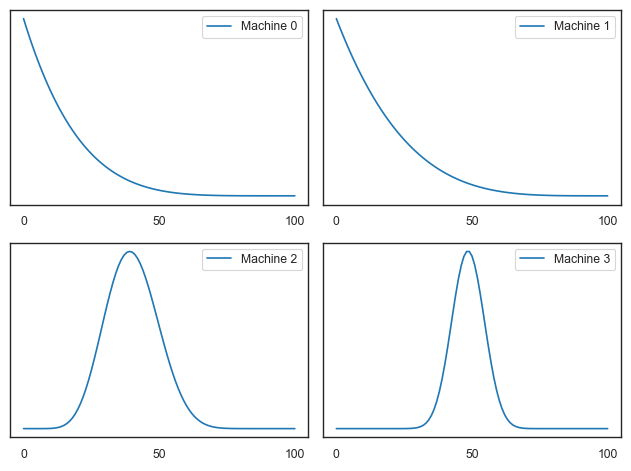

In [21]:
num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)

plot(beliefs)

In [22]:
for i, b in enumerate(beliefs):
    print(b.mean(), b.credible_interval(0.9))

13.86140728464648 [ 0. 39.]
16.25345499309617 [ 1. 45.]
40.00000000000007 [25. 56.]
48.571428571428555 [39. 58.]


The credible intervals usually contain the true values (10, 20, 30, and 40). The estimates are still rough, especially for the lower-probability machines. But that's a feature, not a bug: the goal is to play the high-probability machines most often. Making the estimates more precise is a means to that end, but not an end itself.

Let's see how many times each machine got played. If things go according to plan, the machines with higher probabilities should get played more often.

In [23]:
for machine, count in sorted(counter.items()):
    print(machine, count)

0 5
1 4
2 23
3 68


## $\varepsilon$-greedy


The simplest bandits follow semi-uniform strategies. The most popular of these is called **epsilon greedy**.

Like the name suggests, the epsilon greedy algorithm follows a greedy arm selection policy, selecting the best-performing arm at each time step. However, $\varepsilon$ percent of the time, it will go off-policy and choose an arm at random. The value of $\varepsilon$ determines the fraction of the time when the algorithm explores available arms, and exploits the ones that have performed the best historically the rest of the time.

This algorithm has a few perks. First, it's easy to explain (explore $\varepsilon$% of time steps, exploit (1 − $\varepsilon$)%. The algorithm fits in a single sentence!). Second, $\varepsilon$ is straightforward to optimize. Third, despite its simplicity, it typically yields pretty good results. Epsilon greedy is the linear regression of bandit algorithms.

Much like linear regression can be extended to a broader family of generalized linear models, there are several adaptations of the epsilon greedy algorithm that trade off some of its simplicity for better performance. One such improvement is to use an epsilon-decreasing strategy. In this version of the algorithm, $\varepsilon$ decays over time. The intuition for this is that the need for exploration decreases over time, and selecting random arms becomes increasingly inefficient as the algorithm eventually has more complete information about the available arms. Another available take on this algorithm is an epsilon-first strategy, where the bandit acts completely random for a fixed amount of time to sample the available arms, and then purely exploits thereafter.

In [24]:
import random

def ind_max(x):
  m = max(x)
  return x.index(m)

In [25]:
class EpsilonGreedy():
  def __init__(self, epsilon, counts, values):
    self.epsilon = epsilon
    self.counts = counts
    self.values = values
    return

  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return

  def select_arm(self):
    if random.random() > self.epsilon:
      return ind_max(self.values)
    else:
      return random.randrange(len(self.values))

  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]

    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

**values:** a vector of floating point numbers that defines the average amount of reward we've gotten when playing each of the $N$ arms available to us. If Arm 1 gave us 1 unit of reward on one play and 0 on another play, while Arm 2 gave us 0 units of reward on both plays, then we'll set values = [0.5, 0.0]

**counts:** a vector of integers of length $N$ that tells us how many times we've played each of the $N$ arms available to us in the current bandit problem. If there are two arms, Arm 1 and Arm 2, which have both been played twice, then we'll set counts = [2, 2]

In [26]:
epsilon = 0.1
values = [0.1, 0.2, 0.3, 0.4]
counts = [4, 4, 4, 4]
algo = EpsilonGreedy(epsilon, counts, values)
# algo.initialize(4)

In [27]:
algo.values

[0.1, 0.2, 0.3, 0.4]

In [28]:
algo.counts

[4, 4, 4, 4]

In [29]:
for i in range(num_plays):
    n_arm = algo.select_arm()
    algo.update(n_arm, 1)

In [30]:
algo.counts

[6, 6, 7, 97]

## UCB (Upper Confidence Bound Algorithm)


Epsilon greedy performs pretty well, but it's easy to see how selecting arms at random can be inefficient. If you have one movie that 50% of users have liked, and another at 5% have liked, epsilon greedy is equally likely to pick either of these movies when exploring random arms. Upper Confidence Bound algorithms were introduced as a class of bandit algorithm that explores more efficiently.

Upper Confidence Bound algorithms construct a confidence interval of what each armэs true performance might be, factoring in the uncertainty caused by variance in the data and the fact that weэre only able to observe a limited sample of pulls for any given arm. The algorithms then optimistically assume that each arm will perform as well as its upper confidence bound (UCB), selecting the arm with the highest UCB.

This has a number of nice qualities. First, you can parameterize the size of the confidence interval to control how aggressively the bandit explores or exploits (e.g. you can run a 99% confidence interval to explore heavily, or a 50% confidence interval to mostly exploit). Second, using upper confidence bounds causes the bandit to explore more efficiently than an epsilon greedy bandit. This happens because confidence intervals shrink as you see additional data points for a given arm. So, while the algorithm will gravitate toward picking arms with high average performance, it will periodically give less-explored arms a chance since their confidence intervals are wider.

A good UCB algorithm to start with is UCB1. UCB1 uses Hoeffding's inequality to assign an upper bound to an arm's mean reward where there's high probability that the true mean will be below the UCB assigned by the algorithm. The inequality states that: $$P(\mu_a > \hat{\mu}_{t, a} + U_t(a)) \leqslant e^{-2t U_t(a)^2},$$ where $\mu_a$ is arm $a$'s true mean reward, $\hat{\mu}_{t, a}$ is
$a$'s observed mean reward at time $t$, and $U_t(a)$ is an upper confidence bound value for arm $a$ which when added the mean reward, gives you an upper confidence bound. Setting $p = e^{-2t U_t(a)^2}$ gives us the following value for the UCB term: $$U_t(a) = \sqrt{\frac{-log(p)}{2 n_a}}.$$

Note that in the denominator we're replacing $t$ with $n_a$, since it represents the number of times arm $a$ has been pulled, which will eventually differ from the total number of time steps $t$ the algorithm has been running at a given point in time.

Setting the probability $p$ of the true mean being greater than the UCB to be less than or equal to $t^{-4}$, a small probability that quickly converges to zero as the number of rounds $t$ grows, ultimately gives us the UCB1 algorithm, which pulls the arm that maximizes: $$\overline{x}_{t, a} + \sqrt{\frac{2log(t)}{n_a}}.$$

Here $\overline{x}_{t, a}$ is the mean observed reward of arm $a$ at time $t$, $t$ is the current time step in the algorithm, and $n_a$ is the number of times arm $a$ has been pulled so far.

Putting this all together, it means that a high "like" rate for a movie in this dataset will increase the likelihood of an arm being pulled, but so will a lower number of times the arm has been pulled so far, which encourages exploration. Also notice that the part of the function that includes the number of time steps the algorithm has been running ($t$) is inside a logarithm, which causes the algorithm's propensity to explore to decay over time.

An extension of UCB1 that goes a step further is the Bayesian UCB algorithm. This bandit algorithm takes the same principles of UCB1, but lets you incorporate prior information about the distribution of an arm's rewards to explore more efficiently (the Hoeffding inequality's approach to generating a UCB1's confidence bound makes no such assumptions).

Going from UCB1 to a Bayesian UCB can be fairly simple. If you assume the rewards of each arm are normally distributed, you can simply swap out the UCB term from UCB1 with $$\frac{c \sigma(x_a)}{\sqrt{n_a}},$$ where $\sigma(x_a)$ is the standard deviation of arm $a$'s rewards, $c$ is an adjustable hyperparameter for determining the size of the confidence interval you're adding to an arm's mean observed reward, $n_a$ is the number of times arm $a$ has been pulled, and $\overline{x}_a \pm \frac{c \sigma(x_a)}{\sqrt{n_a}}$ is a confidence interval for arm $a$ (so a 95% confidence interval can be represented with $c$ = 1.96). It's common to see this outperform UCB1 in practice.

In [31]:
import math

class UCB1():
  def __init__(self, counts, values):
    self.counts = counts
    self.values = values
    return

  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return

  def select_arm(self):
    n_arms = len(self.counts)
    for arm in range(n_arms):
      if self.counts[arm] == 0:
        return arm

    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(self.counts)
    for arm in range(n_arms):
      bonus = math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))
      ucb_values[arm] = self.values[arm] + bonus
    return ind_max(ucb_values)

  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]

    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

In [32]:
values = [0.1, 0.2, 0.3, 0.4]
counts = [4, 4, 4, 4]
ucb_algo = UCB1(counts, values)

In [33]:
for i in range(num_plays):
    n_arm = ucb_algo.select_arm()
    ucb_algo.update(n_arm, 1)

In [34]:
ucb_algo.values, ucb_algo.counts

([0.8615384615384613,
  0.8857142857142856,
  0.9066666666666667,
  0.9249999999999996],
 [26, 28, 30, 32])

## Recommender system

In [36]:
rating_df = pd.read_csv('./top-n-movies_user-ratings.csv').drop(columns = 'Unnamed: 0')
rating_df.head()

,user_id,movie_id,rating,movie_title
0,307,0,4,Toy Story
1,250,99,4,Fargo
2,24,180,5,Return of the Jedi
3,19,287,1,Scream
4,31,293,3,Liar Liar


In [37]:
reward_threshold = 4
rating_df['reward'] = rating_df.eval('rating > @reward_threshold').astype(int)
rating_df.head()

,user_id,movie_id,rating,movie_title,reward
0,307,0,4,Toy Story,0
1,250,99,4,Fargo,0
2,24,180,5,Return of the Jedi,1
3,19,287,1,Scream,0
4,31,293,3,Liar Liar,0


**Task:** Build a movie recommender system. The algorithm can be the following:



1.   Run 2000 visits for 20 iterations.
>1.   In each visit randomly select a user.
>2.   Select a movie using the Bandit algorithm for this user until you find that the user has evaluated the selected movie.
>3.   Once you have selected the movie that the user has evaluated, save the number of times the movie appeared within the current iteration and the average value of the reward.
>4.   Calculate the total reward (number of correctly suggested movies in the current iteration by the end of this visit).
>5.   Calculate the fraction relevance of the visit (average reward obtained in the current iteration by the end of this visit).
>6.   Save information about the iteration number, visit number, item_id, visitor_id (aka user_id), reward, total_reward, and fraction_relevance.
2. Make the plot as below but for different values of $\varepsilon$ and different number of iterations.

In [38]:
unique_users: list[int] = list(set(rating_df.user_id))
unique_films: list[int] = list(set(rating_df.movie_id))
idx2movie_id = {i: movie_id for i, movie_id in enumerate(unique_films)}
eps_algo = EpsilonGreedy(0.1, [], [])
eps_algo.initialize(len(unique_films))

n_visits = 2000
n_iters = 20
results = dict(
  iteration=[],
  visit=[],
  movie_id=[],
  user_id=[],
  reward=[],
  total_reward=[],
  fraction_relevant=[],
)

for i in tqdm(range(n_iters)):
  total_reward = 0
  eps_algo.initialize(len(unique_films))

  for j in range(n_visits):
    reward = -1
    user_id = -1
    movie_id = -1
    arm_idx = -1

    while reward < 0:
      # Select user
      user_id = np.random.choice(unique_users)

      # Select movie
      arm_idx = eps_algo.select_arm()
      movie_id = idx2movie_id[arm_idx]

      rewards = rating_df.query(
        f"movie_id == {movie_id} and user_id == {user_id}"
      ).reward
      reward = rewards.iloc[0] if not rewards.empty else reward

    # Record
    total_reward += reward
    eps_algo.update(arm_idx, reward)
    results['iteration'].append(i + 1)
    results['visit'].append(j + 1)
    results['movie_id'].append(movie_id)
    results['user_id'].append(user_id)
    results['reward'].append(reward)
    results['total_reward'].append(total_reward)
    results['fraction_relevant'].append(total_reward / (j + 1))

results_df = pd.DataFrame(results)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


In [39]:
epsilon_10_avg_results_df = results_df.groupby(["visit"], as_index=False).mean()
epsilon_10_avg_results_df

,visit,iteration,movie_id,user_id,reward,total_reward,fraction_relevant
0,1,10.5,29.00,490.00,0.25,0.25,0.250000
1,2,10.5,2.45,471.65,0.45,0.70,0.350000
2,3,10.5,6.00,470.40,0.20,0.90,0.300000
3,4,10.5,15.30,514.65,0.20,1.10,0.275000
4,5,10.5,44.90,525.20,0.25,1.35,0.270000
...,...,...,...,...,...,...,...
1995,1996,10.5,66.50,539.05,0.75,1007.15,0.504584
1996,1997,10.5,65.90,399.30,0.65,1007.80,0.504657
1997,1998,10.5,55.10,529.70,0.50,1008.30,0.504655
1998,1999,10.5,83.10,548.10,0.20,1008.50,0.504502


<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
/var/folders/n8/nv3d2csn3_l3w70gs_g9srfr0000gn/T/ipykernel_71607/974932649.py:18: SyntaxWarning: invalid escape sequence '\e'
  ax.legend(['$\epsilon$ = 0.10'],


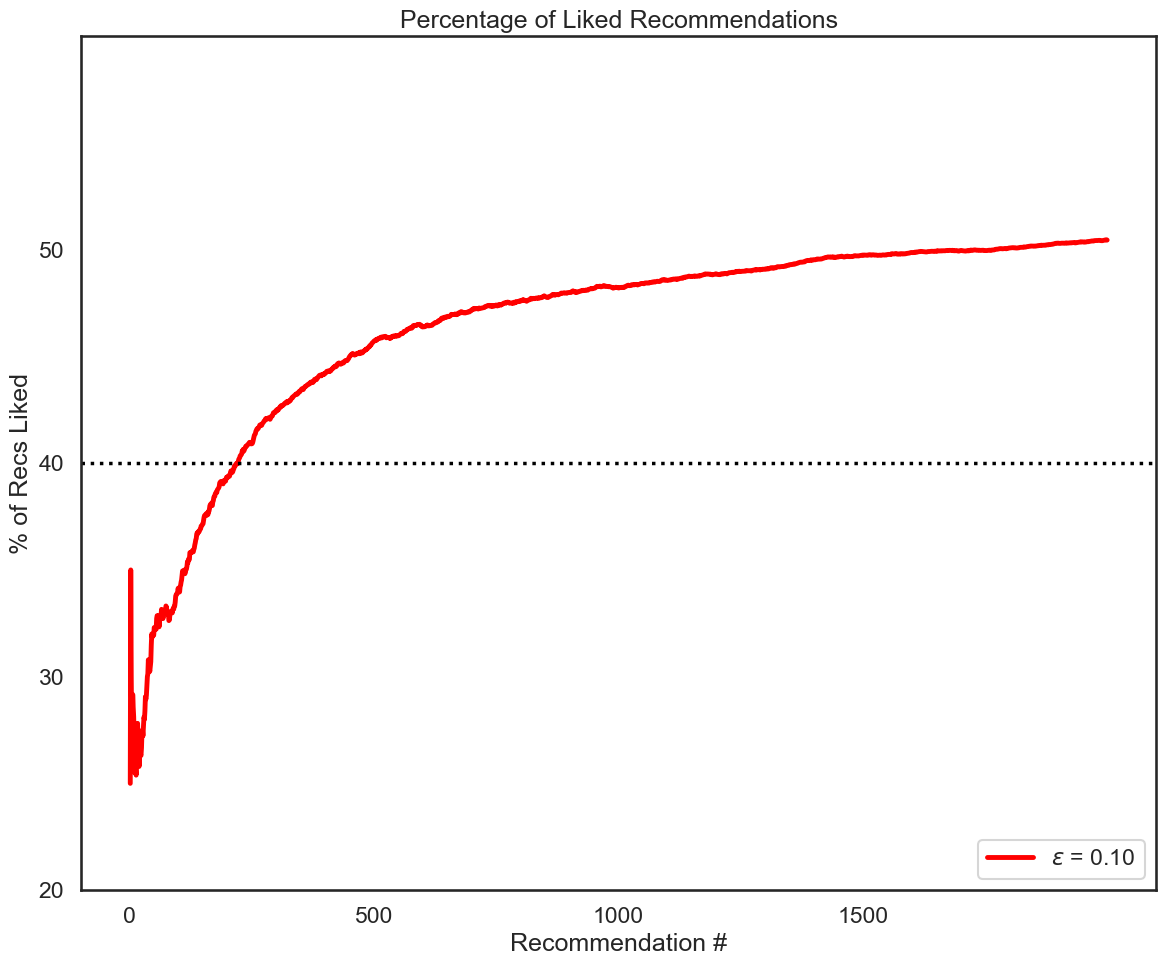

In [40]:
# make this plot for a different number of iterations and epsilon

fig, ax = plt.subplots(figsize = (12, 10))
ax.plot(epsilon_10_avg_results_df.visit, epsilon_10_avg_results_df.fraction_relevant, 'r-', linewidth = 3.5)
ax.axhline(y = 0.4, color = 'k', linestyle = ':', linewidth = 2.5)

ax.set_title('Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

ax.set_xticks(range(0, 2000, 500))
ax.set_ylim(0.2, 0.6)
ax.set_yticks(np.arange(0.2, 0.6, 0.1))

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['$\epsilon$ = 0.10'],
          loc = 'lower right'
         )

plt.tight_layout()
plt.show()

In [41]:
eps_algo1 = EpsilonGreedy(0.5, [], [])
eps_algo1.initialize(len(unique_films))

n_visits = 2000
n_iters = 20
results1 = dict(
  iteration=[],
  visit=[],
  movie_id=[],
  user_id=[],
  reward=[],
  total_reward=[],
  fraction_relevant=[],
)

for i in tqdm(range(n_iters)):
  total_reward = 0
  eps_algo1.initialize(len(unique_films))

  for j in range(n_visits):
    reward = -1
    user_id = -1
    movie_id = -1
    arm_idx = -1

    while reward < 0:
      # Select user
      user_id = np.random.choice(unique_users)

      # Select movie
      arm_idx = eps_algo1.select_arm()
      movie_id = idx2movie_id[arm_idx]

      rewards = rating_df.query(
        f"movie_id == {movie_id} and user_id == {user_id}"
      ).reward
      reward = rewards.iloc[0] if not rewards.empty else reward

    # Record
    total_reward += reward
    eps_algo1.update(arm_idx, reward)
    results1['iteration'].append(i + 1)
    results1['visit'].append(j + 1)
    results1['movie_id'].append(movie_id)
    results1['user_id'].append(user_id)
    results1['reward'].append(reward)
    results1['total_reward'].append(total_reward)
    results1['fraction_relevant'].append(total_reward / (j + 1))

results_df1 = pd.DataFrame(results1)

100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


In [42]:
epsilon_10_avg_results_df1 = results_df1.groupby(["visit"], as_index=False).mean()
epsilon_10_avg_results_df1

,visit,iteration,movie_id,user_id,reward,total_reward,fraction_relevant
0,1,10.5,125.25,489.40,0.25,0.25,0.250000
1,2,10.5,120.75,351.35,0.20,0.45,0.225000
2,3,10.5,156.75,513.65,0.20,0.65,0.216667
3,4,10.5,138.05,512.80,0.30,0.95,0.237500
4,5,10.5,162.70,514.80,0.40,1.35,0.270000
...,...,...,...,...,...,...,...
1995,1996,10.5,81.15,412.25,0.40,846.85,0.424274
1996,1997,10.5,90.75,566.85,0.40,847.25,0.424261
1997,1998,10.5,87.75,485.30,0.45,847.70,0.424274
1998,1999,10.5,147.30,565.70,0.60,848.30,0.424362


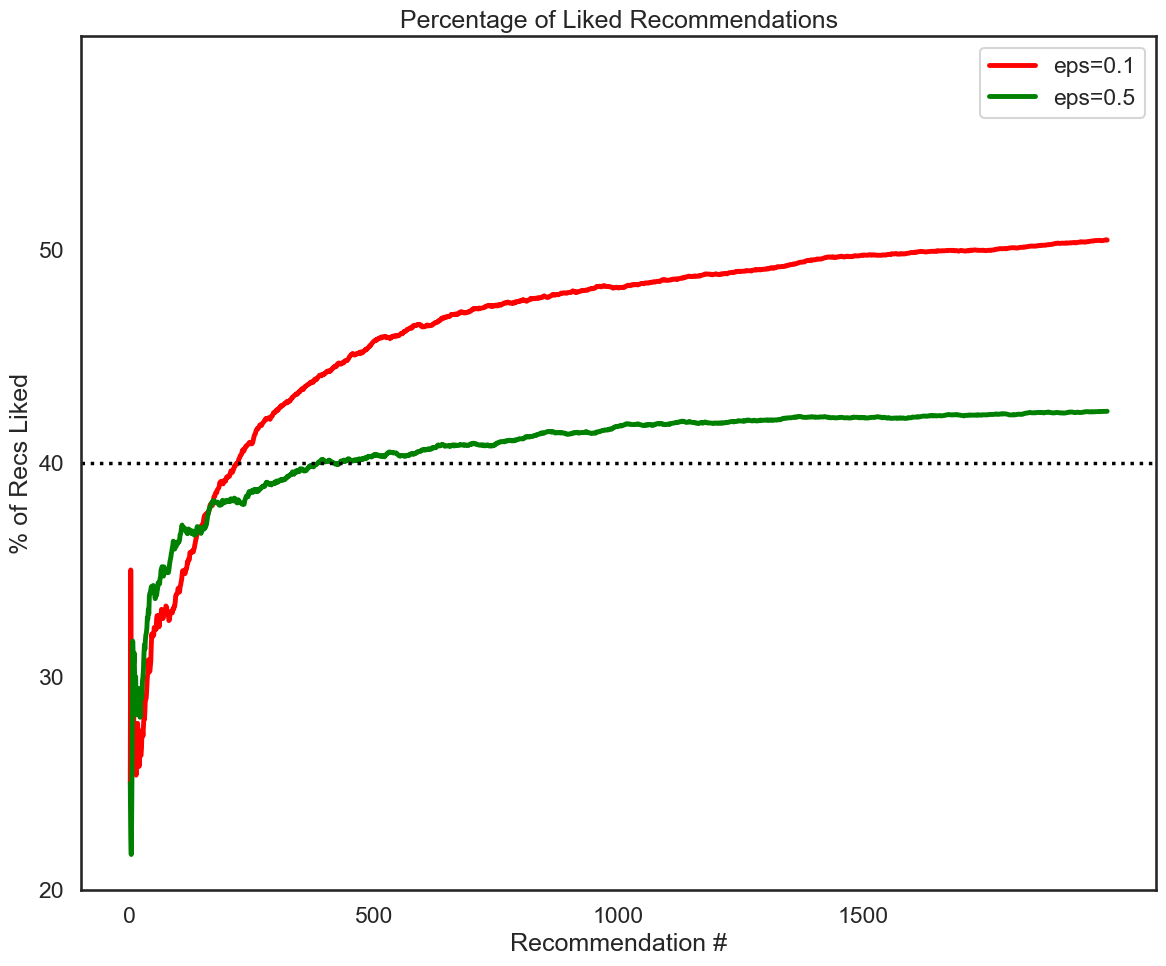

In [44]:
# make this plot for a different number of iterations and epsilon

fig, ax = plt.subplots(figsize = (12, 10))
ax.plot(epsilon_10_avg_results_df.visit, epsilon_10_avg_results_df.fraction_relevant, 'r-', linewidth = 3.5, label=f"eps={eps_algo.epsilon}")
ax.plot(epsilon_10_avg_results_df1.visit, epsilon_10_avg_results_df1.fraction_relevant, 'g-', linewidth = 3.5, label=f"eps={eps_algo1.epsilon}")
ax.axhline(y = 0.4, color = 'k', linestyle = ':', linewidth = 2.5)

ax.set_title('Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

ax.set_xticks(range(0, 2000, 500))
ax.set_ylim(0.2, 0.6)
ax.set_yticks(np.arange(0.2, 0.6, 0.1))

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend()

plt.tight_layout()
plt.show()

## Useful Sources



*   [Good sourses of Bayesian statistics](https://github.com/AllenDowney/BayesMadeSimple)
